## Setup

In [7]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

from src.config import RAW_DATA_PATH
from src.train import ChurnModelTrainer

## Quick model comparison

In [8]:
# Load and prepare data
df = pd.read_csv(RAW_DATA_PATH / "WA_Fn-UseC_-Telco-Customer-Churn.csv")
trainer = ChurnModelTrainer()
X_train, X_val, X_test, y_train, y_val, y_test, encoder = trainer.prepare_data(df)

# Train baseline
baseline_model, scaler, baseline_auc = trainer.train_baseline(X_train, X_val, y_train, y_val)

# Train XGBoost
xgb_model, xgb_auc = trainer.train_xgboost(X_train, X_val, y_train, y_val)

print(f"Baseline AUC: {baseline_auc:.4f}")
print(f"XGBoost AUC: {xgb_auc:.4f}")
print(f"Improvement: {((xgb_auc - baseline_auc) / baseline_auc * 100):.1f}%")


INFO:src.train:Preparing data for training...
INFO:src.feature_engineering:Created 31 features
INFO:src.train:Train shape: (4225, 30), Val shape: (1409, 30), Test shape: (1409, 30)
INFO:src.train:Class distribution - Train: 26.53%, Val: 26.54%, Test: 26.54%
INFO:src.train:Training baseline model...
2025/08/05 17:51:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/opt/anaconda3/envs/ml-dev/lib/python3.9/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing v

Baseline AUC: 0.8399
XGBoost AUC: 0.8321
Improvement: -0.9%


## Visualize model performance

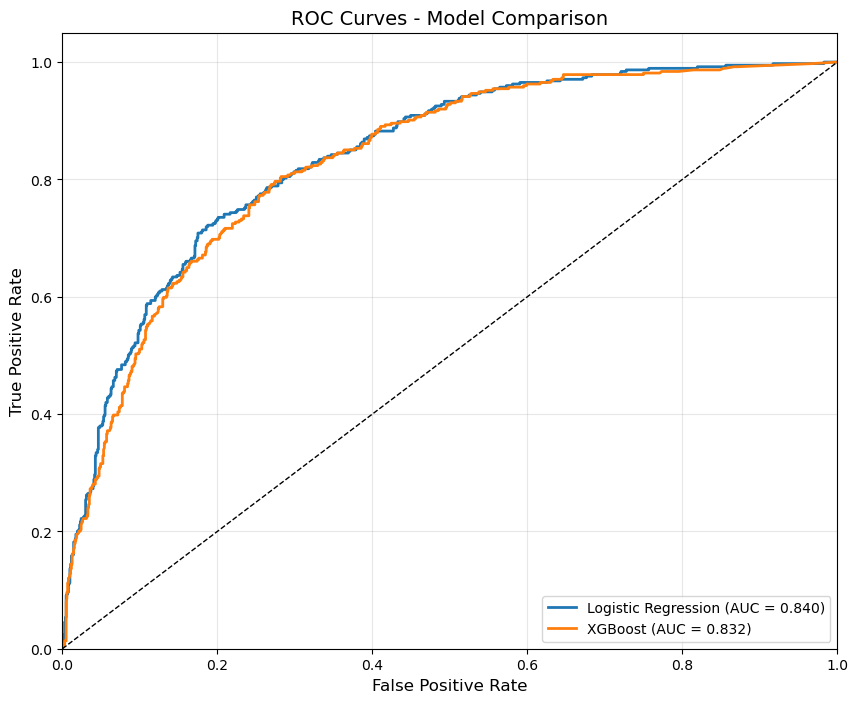

In [9]:
def plot_roc_curves(models, X_val, y_val, scaler=None):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        if name == 'Logistic Regression' and scaler:
            X_val_model = scaler.transform(X_val)
        else:
            X_val_model = X_val
            
        y_pred_proba = model.predict_proba(X_val_model)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Plot ROC curves
models = {
    'Logistic Regression': baseline_model,
    'XGBoost': xgb_model
}
plot_roc_curves(models, X_val, y_val, scaler)

# Get feature importance

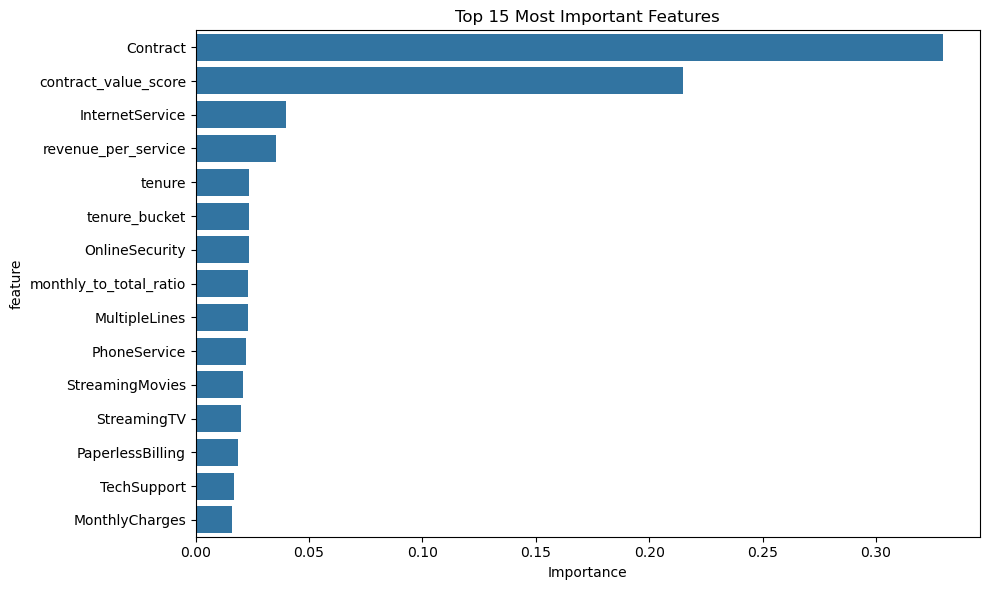

In [10]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, y='feature', x='importance')
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Model Complexity Analysis

In [ ]:
# 1. Learning curves
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation score')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), 
                     alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('AUC Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for both models
plot_learning_curves(baseline_model, X_train, y_train, 
                    'Learning Curves - Logistic Regression')